In [420]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import numpy as np

#### Dataset
In this homework, we will use the California Housing Prices data from Kaggle.

Here's a wget-able link:

https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [421]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

#### Features
For the rest of the homework, you'll need to use only these columns:

* 'latitude',
* 'longitude',
* 'housing_median_age',
* 'total_rooms',
* 'total_bedrooms',
* 'population',
* 'households',
* 'median_income',
* 'median_house_value',
* 'ocean_proximity',

In [422]:
df = df[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms',\
    'population','households','median_income','median_house_value','ocean_proximity']]

In [423]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Data preparation
* Select only the features from above and fill in the missing values with 0.
* Create a new column rooms_per_household by dividing the column total_rooms by the column households from dataframe.
* Create a new column bedrooms_per_room by dividing the column total_bedrooms by the column total_rooms from dataframe.
* Create a new column population_per_household by dividing the column population by the column households from dataframe.

In [424]:
df.fillna(0,inplace=True)

In [425]:
df['rooms_per_household'] = round(df['total_rooms']/df['households'],2)

In [426]:
df['bedrooms_per_room'] = round(df['total_bedrooms']/df['total_rooms'],2)

In [427]:
df['population_per_household'] = round(df['population']/df['households'],2)

In [428]:
df.columns = df.columns.str.lower()
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes == 'float64'].index)+\
list(df.dtypes[df.dtypes == 'int64'].index)

#### Question 1
What is the most frequent observation (mode) for the column ocean_proximity?

In [429]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### Split the data
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
* Make sure that the target value (median_house_value) is not in your dataframe.

In [430]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#### Question 2
* Create the correlation matrix for the numerical features of your train dataset.
* In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

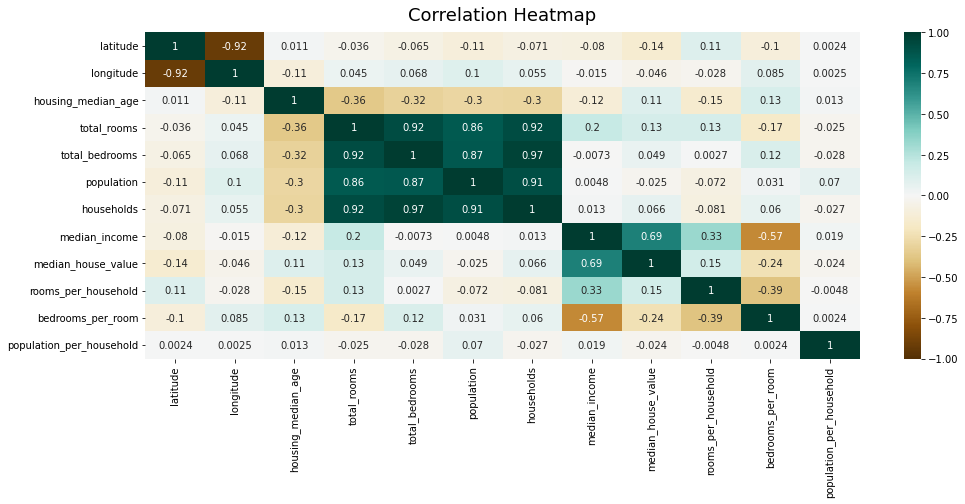

In [431]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[numerical_columns].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

#### Make median_house_value binary
* We need to turn the median_house_value variable from numeric into binary.
* Let's create a variable above_average which is 1 if the median_house_value is above its mean value and 0 otherwise.

In [432]:
df_train['above_average'] = [1 if i >  df_train['median_house_value'].mean() \
                                  else 0 for i in df_train['median_house_value'] ]

df_val['above_average'] = [1 if i >  df_val['median_house_value'].mean() \
                                  else 0 for i in df_val['median_house_value'] ]

df_test['above_average'] = [1 if i >  df_test['median_house_value'].mean() \
                                  else 0 for i in df_test['median_house_value'] ]
numerical_columns.remove('median_house_value')

####  Question 3
* Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
* What is the value of mutual information?
* Round it to 2 decimal digits using round(score, 2)

In [433]:
round(mutual_info_score(df_train.ocean_proximity, df_train.above_average),2)

0.1

#### Question 4
* Now let's train a logistic regression
* Remember that we have one categorical variable ocean_proximity in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
* To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [434]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

df_train.drop(columns=['median_house_value','above_average'],inplace=True)
df_val.drop(columns=['median_house_value','above_average'],inplace=True)
df_test.drop(columns=['median_house_value','above_average'],inplace=True)

In [435]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [436]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [437]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [438]:
 round(accuracy_score(y_val, y_pred),2)

0.83

#### Question 5
* Let's find the least useful feature using the feature elimination technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
* Which of following feature has the smallest difference?
1) total_rooms
2) total_bedrooms
3) population
4) households

In [439]:
dv = DictVectorizer(sparse=False)
accuracy = {}
for col in ['total_rooms','total_bedrooms','population','households']:
    df_train_drop = df_train.drop(columns= col)
    df_val_drop = df_val.drop(columns=col)
    train_dict = df_train_drop.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val_drop.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy['dropping_'+col+'_accuracy'] =  round(accuracy_score(y_val, y_pred)-0.83,2)

In [440]:
accuracy

{'dropping_total_rooms_accuracy': -0.01,
 'dropping_total_bedrooms_accuracy': -0.0,
 'dropping_population_accuracy': -0.01,
 'dropping_households_accuracy': -0.01}

#### Question 6
* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column 'median_house_value'. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model (model = Ridge(alpha=a, solver="sag", random_state=42)) on the training data.
* This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.
* If there are multiple options, select the smallest alpha.

In [409]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [410]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train['median_house_value']).values
y_val = np.log1p(df_val['median_house_value']).values
y_test =np.log1p(df_test['median_house_value']).values

In [411]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.drop(columns=['median_house_value']).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.drop(columns=['median_house_value']).to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.drop(columns=['median_house_value']).to_dict(orient='records')
X_test = dv.transform(test_dict)

In [412]:
rmse = {}
for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train,y_train)
    y_pred  = model.predict(X_val)
    rmse['alpha='+str(a)]= mean_squared_error(y_val, y_pred)

In [413]:
rmse 

{'alpha=0': 0.2817704189418741,
 'alpha=0.01': 0.2817704189633273,
 'alpha=0.1': 0.2817704191671292,
 'alpha=1': 0.28177042121586354,
 'alpha=10': 0.2817788180932017}

In [443]:
 import operator
print('best_alpha :'max(rmse .items(), key=operator.itemgetter(1))[0]

'alpha=10'